In [188]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import scipy as sp
import os

In [189]:
# relavant physical constants

mu_B = 9.274*10**-24
h_bar = 1.054*10**-34
h = h_bar*2*np.pi
c= 299792458

In [190]:
# import all data 
mercury_data = pd.DataFrame({
        'wavelength': [], 
        'polarization': [], 
        'b-field': [], 
        'data': []
    }
).astype({'data':'object'})

mercury_data.set_index(['wavelength', 'polarization', 'b-field'], inplace=True)

mercury_dir = './data/mercury'  
neon_dir = './data/neon'

# upload everything into the dataframe

for file in os.listdir(mercury_dir):
    filename = os.fsdecode(file)
    key = tuple(filename.replace('.tsv', '').split("_"))
    
    data_to_store = pd.read_csv(os.path.join(mercury_dir, filename), sep = '\t', names = ['wavelength', 'counts'])
    mercury_data.loc[key, 'data']=[data_to_store]
    


print(mercury_data.loc[('404.7nm', '024deg', '0.9T'), 'data'])

[     wavelength  counts
0       405.100     146
1       405.101     158
2       405.102     170
3       405.103     170
4       405.104     202
..          ...     ...
96      405.196     186
97      405.197     186
98      405.198     158
99      405.199     154
100     405.200     172

[101 rows x 2 columns]]


('404.7nm', '024deg')
Theorized resolution: 0.021071676970898817
[4.05150496e+02 4.44015570e-04]
('404.7nm', '114deg')
Theorized resolution: 0.02206267782654958
[4.05150053e+02 4.86761753e-04]
('435.8nm', '024deg')
Theorized resolution: 0.019717796064586224
[4.36323364e+02 3.88791482e-04]
('435.8nm', '114deg')
Theorized resolution: 0.025021657910844534
[4.36323380e+02 6.26083365e-04]
('546.1nm', '024deg')
Theorized resolution: 0.00616959740167429
[5.46591001e+02 3.80639321e-05]
('546.1nm', '114deg')
Theorized resolution: 0.004247068366108507
[5.46591000e+02 1.80375897e-05]


C:\Users\Ali\AppData\Local\Temp\ipykernel_6004\1513025337.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  param1, param2 = sp.optimize.curve_fit(f=sp.stats.norm.pdf, xdata=xdata, ydata=ydata, p0 = [float(index[0].replace("nm", "")), 0.1] )


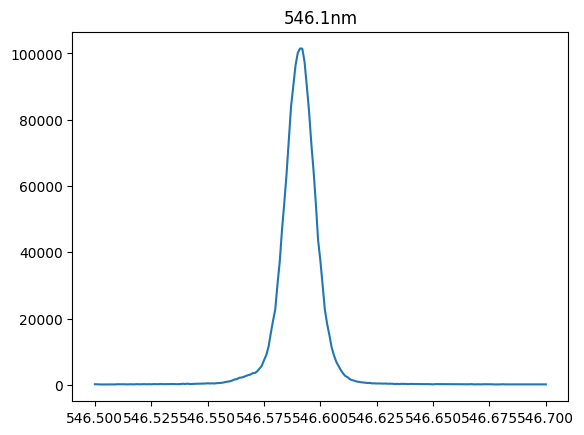

In [191]:
# example of choosing a datapoint

chosen_data = mercury_data.loc[("546.1nm", "024deg", "1.4T"), 'data'][0]

# example of filtering based off of a certain metric 

all_114 = mercury_data.xs('0.0T', level='b-field')


# Fit all data to get its half-width with a gaussian distribution, see if the resolution is the same across the board

for index, row in all_114.iterrows(): 
    xdata = row["data"][0]["wavelength"].tolist()    
    ydata = row["data"][0]["counts"].tolist()
    print(index)
    param1, param2 = sp.optimize.curve_fit(f=sp.stats.norm.pdf, xdata=xdata, ydata=ydata, p0 = [float(index[0].replace("nm", "")), 0.1] )
    print(f"Theorized resolution: {np.sqrt(param1[1])}")
    if(index[0]=='546.1nm' and index[1]=='114deg'):
        plt.plot(xdata,ydata)
    plt.title('546.1nm')
    print(param1)    

plt.show()

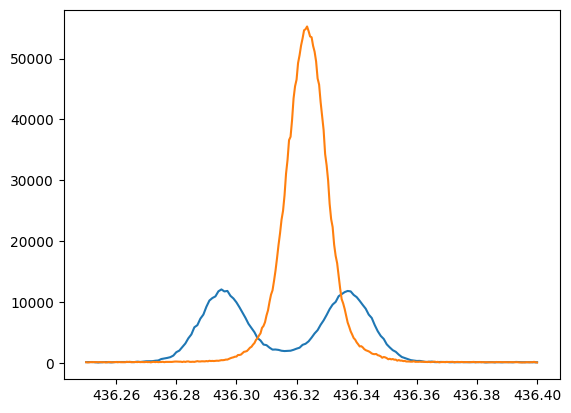

In [192]:
# plot the 0T vs 1.5T of the 435.8nm line

# think about the π lines, which have Δm = 0


line435 = mercury_data.xs("435.8nm", level='wavelength').xs("024deg", level="polarization")

high_field = line435.loc[("1.4T"), 'data'][0]
no_field = line435.loc[("0.0T"), 'data'][0]

plt.plot(high_field["wavelength"], high_field["counts"])
plt.plot(no_field["wavelength"], no_field["counts"])

In [301]:
def provide_allowable_transitions(sigma_or_pi, Ji,Jf):
    ret_list = []
    
    start = np.arange(-Ji, Ji+1)
    end = np.arange(-Jf, Jf+1)

    if sigma_or_pi == "pi":
        # calculate list of levels
        for level in start:
            if level in end:
                ret_list.append((level, level))
        return ret_list
    elif sigma_or_pi == "sigma":
        for level in start:
            if (level+1) in end: 
                ret_list.append((level, level+1))
            if (level-1) in end:
                ret_list.append((level, level-1))
        return ret_list
    else:
        return -1

# Define transition numbers (J, S, L)

def g_lande(state):
    # unpack state
    J, L, S = state
    
    return 1+(J*(J+1)+S*(S+1)-L*(L+1))/(2*J*(J+1))

def g_eff(statei, statef, transition):
    mi, mf = transition
    return g_lande(statef)*mf - g_lande(statei)*mi


def lambda_shift(wavelength, g_eff, b_field):
    return g_eff*wavelength**2*mu_B/h/c*b_field

def intensity_plot(wavelength, delta_wavelength, wavelength_0):
    return 1/np.pi/delta_wavelength*(1/(1+(wavelength-wavelength_0)**2/delta_wavelength**2))


def generate_plot(xdata, ydata, statei, statef, wavelength, b_field, type, resolution):
    
    fit, sigma = sp.optimize.curve_fit(f=sp.stats.norm.pdf, xdata=xdata, ydata=ydata, p0 = [wavelength, 0.1] )
    print(fit)
    exp_wavelength = fit[0]
    
    norm = np.max(ydata)
    transitions = provide_allowable_transitions(sigma_or_pi=type, Ji = statei[0], Jf=statef[0])
    yrange = np.zeros(len(xdata))
    for transition in transitions:
        shift = lambda_shift(exp_wavelength*10**-9, g_eff(statei,statef,transition)*10**9, b_field)
        to_add =  [intensity_plot(x,resolution, exp_wavelength+shift) for x in xdata]
        yrange = yrange+to_add
    scaling_ratio = norm/np.max(yrange)
    yrange = scaling_ratio*yrange
    plt.plot(xdata,yrange)

In [302]:
provide_allowable_transitions("pi", 1, 1)

# Now calculate, the wavelength shift expected for each transition using the Landé g-factor


three_S_one = (1, 0, 1)
three_P_one = (1,1,0)

transitions= provide_allowable_transitions("sigma", three_S_one[0], three_P_one[0])

for transition in transitions:
    print(f'Transition of {transition}: geff = {g_eff(three_S_one, three_P_one, transition)}')
    
# Routine to fit against a given plot
    


Transition of (-1, 0): geff = 2.0
Transition of (0, 1): geff = 1.0
Transition of (0, -1): geff = -1.0
Transition of (1, 0): geff = -2.0


[(-1, 0), (0, 1), (0, -1), (1, 0)]


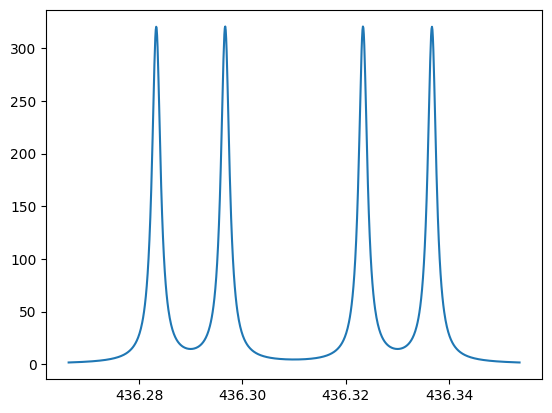

In [303]:
# Now that we have the possible allowable transitions, let's plot them 

print(transitions)
chosen_wavelength = 436.31
xrange = np.linspace(chosen_wavelength*0.9999, chosen_wavelength*1.0001, 1000)
yrange = np.zeros(1000)

for transition in transitions:
    to_add = [intensity_plot(x,0.001, chosen_wavelength+lambda_shift(chosen_wavelength*10**-9,g_eff(three_S_one,three_P_one,transition)*10**9,1.5)) for x in xrange]
    yrange = yrange+to_add

plt.plot(xrange, yrange)

[4.3633702e+02 2.4381055e-05]


C:\Users\Ali\AppData\Local\Temp\ipykernel_6004\3306343828.py:45: OptimizeWarning: Covariance of the parameters could not be estimated
  fit, sigma = sp.optimize.curve_fit(f=sp.stats.norm.pdf, xdata=xdata, ydata=ydata, p0 = [wavelength, 0.1] )


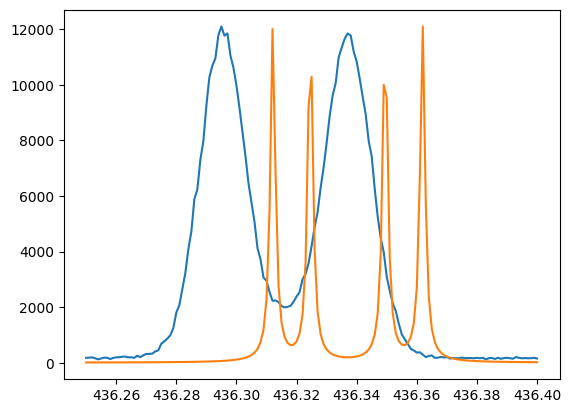

In [305]:
# DEMO ON HOW TO USE THE TOOL


# Step 1: Define your transition in terms of (J, L, S)
three_P_two = (2,1,1)
three_S_one = (1,0,1)

# Step 2: Pick which data point you want to do 
high_field = mercury_data.loc[("435.8nm", "024deg", "1.4T"), 'data'][0]

# Step 3: Plot the experimental
plt.plot(high_field["wavelength"], high_field["counts"])


# Step 4: Generate simulation fit from theoretical

# PARAMS (experimental x, experimental y, initial state, final state, wavelength, b field, sigma/pi)
generate_plot(high_field["wavelength"], high_field["counts"], three_S_one, three_P_one,435.8,1.4, "sigma", 0.001)